<a href="https://colab.research.google.com/github/WHU-Peter/COMP6200-Project/blob/main/project_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import nn
from torch import optim
from torch.optim import *
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
import math
import matplotlib.pyplot as plt

# fix random seed for reproducibility
seed = 7
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import numpy as np
np.random.seed(seed)

device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [2]:
# flatten 28*28 images to a 784 vector for each image
transform = transforms.Compose([
    transforms.ToTensor(),  # convert to tensor
    transforms.Lambda(lambda x: x.view(-1))  # flatten into vector
])

trainset = MNIST(".", train=True, download=True, transform=transform)
testset = MNIST(".", train=False, download=True, transform=transform)

# create data loaders
trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)

class_counts = torch.zeros(10, dtype=torch.int32)

for (images, labels) in trainloader:
  for label in labels:
    class_counts[label] += 1

assert class_counts.sum()==60000

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Baseline model, two linear layers. 

In [3]:
# define baseline model
class BaselineModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BaselineModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out

In [4]:
# build the model 
baseline_model = BaselineModel(784, 784, 10).to(device)

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(baseline_model.parameters())

Loss_Baseline_Model = []
# the epoch loop
for epoch in range(50):
    running_loss = 0.0
    for data in trainloader:
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = baseline_model(inputs.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        optimiser.step()

        # keep track of the loss this epoch
        running_loss += loss.item()
    print("Epoch %d, loss %4.2f" % (epoch, running_loss))
    Loss_Baseline_Model.append(running_loss)
print('**** Finished Training ****')

Epoch 0, loss 133.89
Epoch 1, loss 51.03
Epoch 2, loss 32.41
Epoch 3, loss 23.11
Epoch 4, loss 16.71
Epoch 5, loss 12.55
Epoch 6, loss 9.47
Epoch 7, loss 6.86
Epoch 8, loss 4.90
Epoch 9, loss 4.12
Epoch 10, loss 3.11
Epoch 11, loss 4.52
Epoch 12, loss 3.15
Epoch 13, loss 2.22
Epoch 14, loss 2.65
Epoch 15, loss 2.57
Epoch 16, loss 2.54
Epoch 17, loss 0.68
Epoch 18, loss 0.30
Epoch 19, loss 0.13
Epoch 20, loss 0.07
Epoch 21, loss 0.06
Epoch 22, loss 0.05
Epoch 23, loss 7.83
Epoch 24, loss 3.48
Epoch 25, loss 0.73
Epoch 26, loss 0.16
Epoch 27, loss 0.07
Epoch 28, loss 0.06
Epoch 29, loss 0.05
Epoch 30, loss 0.04
Epoch 31, loss 0.03
Epoch 32, loss 0.03
Epoch 33, loss 0.02
Epoch 34, loss 0.02
Epoch 35, loss 0.02
Epoch 36, loss 0.01
Epoch 37, loss 0.01
Epoch 38, loss 9.36
Epoch 39, loss 4.34
Epoch 40, loss 0.51
Epoch 41, loss 0.11
Epoch 42, loss 0.05
Epoch 43, loss 0.04
Epoch 44, loss 0.03
Epoch 45, loss 0.02
Epoch 46, loss 0.02
Epoch 47, loss 0.02
Epoch 48, loss 0.01
Epoch 49, loss 0.01
***

Compute the model accuracy on the test set

In [5]:
class_correct = torch.zeros(10)
class_total = torch.zeros(10)
baseline_model.eval()
for (images, labels) in testloader:

  for label in labels:
    class_total[label] += 1
  
  outputs = baseline_model(images.to(device))
  outputs = outputs.to("cpu")
  for i in range(outputs.shape[0]):
    _, prediction = outputs[i].max(0)
    if prediction == labels[i]:
      class_correct[labels[i]] += 1

for i in range(10):
    print('Class %d accuracy: %2.2f %%' % (i, 100.0*class_correct[i] / class_total[i]))
print("accuracy: %2.2f %%" % (100.0*sum(class_correct)/sum(class_total)))

Class 0 accuracy: 99.18 %
Class 1 accuracy: 99.12 %
Class 2 accuracy: 98.26 %
Class 3 accuracy: 98.51 %
Class 4 accuracy: 98.37 %
Class 5 accuracy: 97.76 %
Class 6 accuracy: 98.43 %
Class 7 accuracy: 98.15 %
Class 8 accuracy: 97.84 %
Class 9 accuracy: 98.12 %
accuracy: 98.39 %


learnable temperature parameter

In [6]:
class SoftMaxWithTemperature(nn.Module):
    def __init__(self):
        super(SoftMaxWithTemperature, self).__init__()
        self.temperature = nn.Parameter(torch.tensor(0.0001))
    def forward(self, x):
        # print(self.temperature)
        return F.softmax(x / self.temperature, dim=-1)

In [7]:
def softmax_temperature(logits, temperature=0.00001):
  pro = F.softmax(logits / temperature, dim=-1)
  # pro = torch.matmul(pro, torch.FloatTensor(range(0, pro.shape[1])));
  return pro;
  # return one_hot_code

In [8]:
def mapping_onehot_vector(vector):
    return vector @ torch.FloatTensor(range(0, vector.shape[1])).to(device)

In [9]:
# define LUTModel
class LUTModelWithLearnableTemperature(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LUTModelWithLearnableTemperature, self).__init__()
        self.softmax_temperature = SoftMaxWithTemperature();
        self.emb = nn.Embedding(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        # if self.training:
        #   out = self.softmax_temperature(x)
        #   out = out @ self.emb.weight
        # else:
        #   out = self.softmax_temperature(x)
        #   out = mapping_onehot_vector(out).round().long()
        #   out = self.emb(out)
        
        out = self.softmax_temperature(x)
        out = out @ self.emb.weight
        # out = self.emb(out.long())
        # out = self.emb(out)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out

In [10]:
# build the model 
learnable_lut_model = LUTModelWithLearnableTemperature(784, 784, 10).to(device)

# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
optimiser = optim.Adam(learnable_lut_model.parameters(), lr=1e-2)

Loss_Learnable_Model = []
Temperature = []
# the epoch loop
for epoch in range(50):
    running_loss = 0.0
    for data in trainloader:
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimiser.zero_grad()

        # forward + loss + backward + optimise (update weights)
        outputs = learnable_lut_model(inputs.to(device))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        optimiser.step()
        # print(optimiser.param_groups[0]['params'][2])
        # print(np.all(optimiser.param_groups[0]['params'][0].grad.numpy() == 0))
        # keep track of the loss this epoch
        running_loss += loss.item()
        # break
    print(optimiser.param_groups[0]['params'][0])
    print("Epoch %d, loss %4.2f" % (epoch, running_loss))
    Loss_Learnable_Model.append(running_loss)
    Temperature.append(optimiser.param_groups[0]['params'][0].detach().cpu().numpy())
print('**** Finished Training ****')

Parameter containing:
tensor(0.2131, device='cuda:0', requires_grad=True)
Epoch 0, loss 166.27
Parameter containing:
tensor(0.2288, device='cuda:0', requires_grad=True)
Epoch 1, loss 58.49
Parameter containing:
tensor(0.1874, device='cuda:0', requires_grad=True)
Epoch 2, loss 35.25
Parameter containing:
tensor(0.1653, device='cuda:0', requires_grad=True)
Epoch 3, loss 21.62
Parameter containing:
tensor(0.1596, device='cuda:0', requires_grad=True)
Epoch 4, loss 14.08
Parameter containing:
tensor(0.1836, device='cuda:0', requires_grad=True)
Epoch 5, loss 9.22
Parameter containing:
tensor(0.1538, device='cuda:0', requires_grad=True)
Epoch 6, loss 5.78
Parameter containing:
tensor(0.1449, device='cuda:0', requires_grad=True)
Epoch 7, loss 3.72
Parameter containing:
tensor(0.1616, device='cuda:0', requires_grad=True)
Epoch 8, loss 2.44
Parameter containing:
tensor(0.1437, device='cuda:0', requires_grad=True)
Epoch 9, loss 1.78
Parameter containing:
tensor(0.1525, device='cuda:0', requires_g

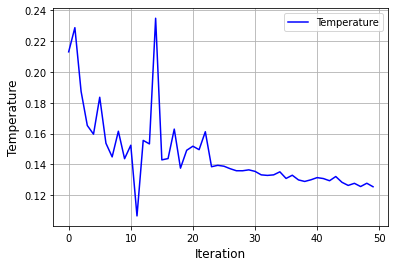

In [11]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,4))
ax.plot(Temperature, Color='blue', label='Temperature')
ax.set_xlabel("Iteration", fontsize=12)
ax.set_ylabel("Temperature", fontsize=12)
# ax.set_title("Linear Model", fontsize=16)
ax.grid()
ax.legend()
# ax.yaxis.set_major_locator(y_major_locator)
plt.show()

In [12]:
# Compute the model accuracy on the test set
class_correct = torch.zeros(10)
class_total = torch.zeros(10)
learnable_lut_model.eval()
for (images, labels) in testloader:

  for label in labels:
    class_total[label] += 1
  
  outputs = learnable_lut_model(images.to(device))
  outputs = outputs.to("cpu")
  for i in range(outputs.shape[0]):
    _, prediction = outputs[i].max(0)
    if prediction == labels[i]:
      class_correct[labels[i]] += 1

for i in range(10):
    print('Class %d accuracy: %2.2f %%' % (i, 100.0*class_correct[i] / class_total[i]))
print("accuracy: %2.2f %%" % (100.0*sum(class_correct)/sum(class_total)))

Class 0 accuracy: 98.47 %
Class 1 accuracy: 99.03 %
Class 2 accuracy: 97.19 %
Class 3 accuracy: 97.92 %
Class 4 accuracy: 97.86 %
Class 5 accuracy: 96.86 %
Class 6 accuracy: 98.12 %
Class 7 accuracy: 97.08 %
Class 8 accuracy: 96.51 %
Class 9 accuracy: 96.53 %
accuracy: 97.58 %


In [13]:
class LUTModelWithAnnealTemperature(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(LUTModelWithAnnealTemperature, self).__init__()
        self.emb = nn.Embedding(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x, temperature):
        # out = self.fc1(x)
        # out = F.relu(out)
        if self.training:
          # print(x.shape)
          # print(self.emb.weight.shape)
          out = softmax_temperature(x, temperature)
          out = out @ self.emb.weight
        else:
          out = softmax_temperature(x, temperature)
          # out = mapping_onehot_vector(out).round().long()
          # out = self.emb(out)

          nozero = torch.nonzero(out);
          # print(np.array(nozero).shape[1])
          for i in range(out.shape[0]):
            idx = torch.where(nozero[:,0]==i)[0]
            rows = nozero[idx, 1].long()
            out[i] = torch.mean(self.emb(rows), axis=0)
          
        # out = self.emb(out.long())
        # out = self.emb(out)
        out = F.relu(out)
        out = self.fc2(out)
        if not self.training:
            out = F.softmax(out, dim=1)
        return out

In [14]:
# build the model 
Annealing_lut_model = LUTModelWithAnnealTemperature(784, 784, 10).to(device)
Annealing_lut_model.train()
# define the loss function and the optimiser
loss_function = nn.CrossEntropyLoss()
learning_rate = 1e-2  #Learning rate
Annealing_lut_optimiser = optim.Adam(Annealing_lut_model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.MultiStepLR(Annealing_lut_optimiser,milestones=[2500],gamma = 0.2)
Loss_Annealing_Model = []
# the epoch loop
i = 0;
for epoch in range(50):
    running_loss = 0.0
    print("Epoch %d, lr %4.5f" % (epoch, Annealing_lut_optimiser.state_dict()['param_groups'][0]['lr']))
    for data in trainloader:
        # get the inputs
        i = i+1
        inputs, labels = data

        # zero the parameter gradients
        Annealing_lut_optimiser.zero_grad()
        # forward + loss + backward + optimise (update weights)
        outputs = Annealing_lut_model(inputs.to(device), max(0.0001, math.exp(-15 * math.pow(10, -5) * (i))))
        loss = loss_function(outputs, labels.to(device))
        loss.backward()
        Annealing_lut_optimiser.step()
        scheduler.step()
        # print(optimiser.param_groups[0]['params'][2])
        # print(np.all(optimiser.param_groups[0]['params'][0].grad.numpy() == 0))
        # keep track of the loss this epoch
        running_loss += loss.item()
        # break
    print("Epoch %d, loss %4.2f" % (epoch, running_loss))
    print("Epoch %d, temperature %4.8f" % (epoch, max(0.0001, math.exp(-20 * math.pow(10, -5) * (i)))))
    Loss_Annealing_Model.append(running_loss)
print('**** Finished Training ****')

Epoch 0, lr 0.01000
Epoch 0, loss 292.31
Epoch 0, temperature 0.91046484
Epoch 1, lr 0.01000
Epoch 1, loss 150.24
Epoch 1, temperature 0.82894622
Epoch 2, lr 0.01000
Epoch 2, loss 119.51
Epoch 2, temperature 0.75472638
Epoch 3, lr 0.01000
Epoch 3, loss 93.42
Epoch 3, temperature 0.68715183
Epoch 4, lr 0.01000
Epoch 4, loss 74.41
Epoch 4, temperature 0.62562758
Epoch 5, lr 0.01000
Epoch 5, loss 56.25
Epoch 5, temperature 0.56961192
Epoch 6, lr 0.00200
Epoch 6, loss 48.60
Epoch 6, temperature 0.51861162
Epoch 7, lr 0.00200
Epoch 7, loss 44.96
Epoch 7, temperature 0.47217764
Epoch 8, lr 0.00200
Epoch 8, loss 41.20
Epoch 8, temperature 0.42990114
Epoch 9, lr 0.00200
Epoch 9, loss 37.97
Epoch 9, temperature 0.39140987
Epoch 10, lr 0.00200
Epoch 10, loss 34.85
Epoch 10, temperature 0.35636493
Epoch 11, lr 0.00200
Epoch 11, loss 31.57
Epoch 11, temperature 0.32445773
Epoch 12, lr 0.00200
Epoch 12, loss 28.40
Epoch 12, temperature 0.29540736
Epoch 13, lr 0.00200
Epoch 13, loss 25.29
Epoch 13, 

In [15]:
# Compute the model accuracy on the test set
class_correct = torch.zeros(10)
class_total = torch.zeros(10)
Annealing_lut_model.eval()
for (images, labels) in testloader:

  for label in labels:
    class_total[label] += 1
  outputs = Annealing_lut_model(images.to(device), 0.001)
  outputs = outputs.to("cpu")
  for i in range(outputs.shape[0]):
    _, prediction = outputs[i].max(0)
    if prediction == labels[i]:
      class_correct[labels[i]] += 1

for i in range(10):
    print('Class %d accuracy: %2.2f %%' % (i, 100.0*class_correct[i] / class_total[i]))
print("accuracy: %2.2f %%" % (100.0*sum(class_correct)/sum(class_total)))

Class 0 accuracy: 98.16 %
Class 1 accuracy: 98.68 %
Class 2 accuracy: 95.83 %
Class 3 accuracy: 96.04 %
Class 4 accuracy: 95.11 %
Class 5 accuracy: 96.19 %
Class 6 accuracy: 97.70 %
Class 7 accuracy: 96.11 %
Class 8 accuracy: 95.38 %
Class 9 accuracy: 95.54 %
accuracy: 96.50 %


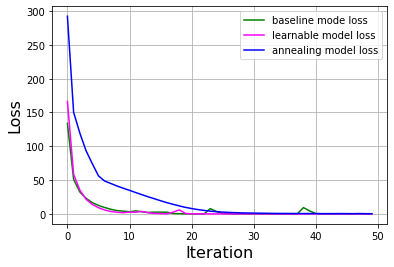

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(6,4))
ax.plot(Loss_Baseline_Model, Color='green', label='baseline mode loss')
ax.plot(Loss_Learnable_Model, Color='magenta', label='learnable model loss')
ax.plot(Loss_Annealing_Model, Color='blue', label='annealing model loss')
ax.set_xlabel("Iteration", fontsize=16)
ax.set_ylabel("Loss", fontsize=16)
# ax.set_title("Linear Model", fontsize=16)
ax.grid()
ax.legend()
# ax.yaxis.set_major_locator(y_major_locator)
plt.show()

In [18]:
# print(Loss_Baseline_Model)
# print(Loss_Learnable_Model)
# print(Loss_Annealing_Model)

[133.89384558796883, 51.03342372737825, 32.40507458336651, 23.10777965001762, 16.70979216368869, 12.546266661724076, 9.471556563861668, 6.862544505740516, 4.898709823726676, 4.1174549061688595, 3.1102976731490344, 4.522631522209849, 3.1456446384690935, 2.2218265631818213, 2.650872945851006, 2.5665689233210287, 2.540784507866192, 0.6775765371039597, 0.30131202457050676, 0.1315830767416628, 0.07129303199963033, 0.05611020378455578, 0.049941577969548234, 7.834702414844287, 3.4785086944539216, 0.726792991070397, 0.1609838954063889, 0.07481821055898763, 0.0565003192587028, 0.04598958829319599, 0.0377345594365579, 0.03202294882635215, 0.02634128652744039, 0.022501306437789026, 0.019201579022137594, 0.016421375716845432, 0.013531854238408414, 0.011113365676919784, 9.360251139725847, 4.3432531131729775, 0.5087863840399223, 0.10824851953884718, 0.05277054374710133, 0.03813306874644695, 0.031001548381027533, 0.02490805915385863, 0.020907338537199394, 0.017460464526152464, 0.014518629660074112, 0